# Deep Learning for Text Classification using Word2Vec

## Import Libraries

In [46]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
nltk.download('punkt')

import gensim
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import Data

In [48]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [49]:
train

,Unnamed: 0,text_a,label
0,0,betewe buka twitter cuman ngetweet liat home b...,no
1,1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,2,e100ss gini buka informasi sejelas nya identit...,yes
3,3,neng solo wes ono terduga corona cobo neng ati...,no
4,4,midiahn nii akun gak takut takut nya isu coron...,no
...,...,...,...
21596,21596,depok panas ga karuan kereta sampe pasming huj...,no
21597,21597,oxfara arie kriting yg lebi goblo nya orang ke...,no
21598,21598,virus corona menyaba depok cuci tangan makan n...,no
21599,21599,mata sipit tinggal depok udah abis dah bahan c...,no


In [50]:
test

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes
...,...,...
2795,ku tenang2 bae ku sih ya corona nya ga depok k...,no
2796,guru hati hati ya virus corona uda indonesia t...,yes
2797,4 terawan menyebut virus corona indonesia terd...,yes
2798,realffk buhari can t pronounce corona virus,no


In [51]:
X_train = train['text_a'].values
y_train = train['label'].values

X_test = test['text_a'].values
y_test = test['label'].values

In [52]:
X_train

array(['betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget',
       'mas piyuuu mugo2 corona tuh mulut tersumpal ma corona',
       'e100ss gini buka informasi sejelas nya identitas daerah penderita terjangkit infokan masyarakat mengisolasi nya kontak langsung penderita positif corona ditutup tutupi',
       ...,
       'virus corona menyaba depok cuci tangan makan nya biar tangan ora lengket be kena nasi',
       'mata sipit tinggal depok udah abis dah bahan cengan dikampus bangsd dikit dikit corona co amp tol',
       'i ak batuk pilek pusing demam anjir ak depok'], dtype=object)

In [53]:
y_train

array(['no', 'no', 'yes', ..., 'no', 'no', 'no'], dtype=object)

In [54]:
X_test

array(['jek dajal ga depok bang',
       'detikcom untung depok masuk wilayah nya ridwan kamil kalo masuk wilayah nya anis abis lu bully ama buzzer kolam',
       'df dom jakarta depok yg gunain vc cabang nya cabang yg tercantum pas kesana gabisa bayar pake shopeepay',
       ...,
       '4 terawan menyebut virus corona indonesia terdeteksi minggu kemarin mendengar berita pemerintah langsung pemeriksaan covid19indonesia',
       'realffk buhari can t pronounce corona virus',
       'hadapi wabah corona pemuda muhammadiyah pemerintah cegah munculnya kepanikan'],
      dtype=object)

In [55]:
y_test

array(['no', 'no', 'no', ..., 'yes', 'no', 'yes'], dtype=object)

## Functions

In [56]:
def clean_data(text):
    normal_tw = text
    normal_tw = text.lower()
    normal_tw = re.sub(r'\\x.{2}', '', normal_tw)
    normal_tw = re.sub(r'((www\.[^\s]*)|(https?://[^\s]*))', '', normal_tw)
    normal_tw = normal_tw.strip()
    normal_tw = re.sub(r'@[^\s]+', '', normal_tw)
    normal_tw = re.sub(r'#[^\s]+', '', normal_tw)
    normal_tw = re.sub(r'\d+', ' ', normal_tw) 
    normal_tw = re.sub(r'^nan$', '', normal_tw) 
    normal_tw = re.sub(r'[_]+', '', normal_tw)
    normal_tw =  re.sub(r'[Ã°Âã¯¹¢²ðƒâ]', '', normal_tw) 
    normal_regex = re.compile(r"(.)\1{1,}")
    normal_tw = normal_regex.sub(r"\1\1", normal_tw)
    normal_tw = re.sub(r'\s+', ' ', normal_tw)
    normal_tw = re.sub(r'[^\w\s]', '', normal_tw) 
    normal_tw = re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', '', normal_tw)
    normal_tw = re.sub(r'[0123456789]', '', normal_tw)
    
    return normal_tw

stopwords_list = set(StopWordRemoverFactory().get_stop_words())

def tokenize_text(text):
    return nltk.word_tokenize(text)

def remove_stopwords(tokenized_text):
    # token = nltk.word_tokenize(text)
    token_afterremoval = []
    for k in tokenized_text:
        if k not in stopwords_list: 
            token_afterremoval.append(k)

    str_clean = ' '.join(token_afterremoval)
    return token_afterremoval

def preprocess(text):
    processed_text = clean_data(text)
    # processed_text = processed_text.lower()
    processed_text = tokenize_text(processed_text)
    processed_text = remove_stopwords(processed_text)
    return processed_text

def find_max_length(data):
    max = len(data[0])
    index = 0
    for i in range(len(data)):
        if max < len(data[i]):
            max = len(data[i])
            index = i
    return max, index

def pad_sequence(arr, max_length):
    for i in range(len(arr)):
        arr[i] = np.asarray(arr[i])
        # for k in range(len(arr[i])):
            # arr[i][k] = float(arr[i][k])
        for j in range(len(arr[i]), max_length):
            # arr[i].append(0.0)
            arr[i] = np.append(arr[i], 0.0)
            # np.concatenate(arr[i], np.array([0]))
    return arr

## Preprocessing

In [57]:
for j in range(len(X_train)):
    X_train[j] = preprocess(X_train[j])

for k in range(len(X_test)):
    X_test[k] = preprocess(X_test[k])

In [58]:
X_train

array([list(['betewe', 'buka', 'twitter', 'cuman', 'ngetweet', 'liat', 'home', 'berita', 'corona', 'panik', 'kepikiran', 'ndamau', 'buka', 'home', 'yg', 'aware', 'aja', 'i', 'll', 'stay', 'at', 'home', 'nda', 'rumah', 'kalo', 'nda', 'penting', 'banget']),
       list(['mas', 'piyuu', 'mugo', 'corona', 'tuh', 'mulut', 'tersumpal', 'ma', 'corona']),
       list(['e', 'ss', 'gini', 'buka', 'informasi', 'sejelas', 'nya', 'identitas', 'daerah', 'penderita', 'terjangkit', 'infokan', 'masyarakat', 'mengisolasi', 'nya', 'kontak', 'langsung', 'penderita', 'positif', 'corona', 'ditutup', 'tutupi']),
       ...,
       list(['virus', 'corona', 'menyaba', 'depok', 'cuci', 'tangan', 'makan', 'nya', 'biar', 'tangan', 'ora', 'lengket', 'be', 'kena', 'nasi']),
       list(['mata', 'sipit', 'tinggal', 'depok', 'udah', 'abis', 'dah', 'bahan', 'cengan', 'dikampus', 'bangsd', 'dikit', 'dikit', 'corona', 'co', 'amp', 'tol']),
       list(['i', 'ak', 'batuk', 'pilek', 'pusing', 'demam', 'anjir', 'ak', 'depo

In [59]:
X_test

array([list(['jek', 'dajal', 'ga', 'depok', 'bang']),
       list(['detikcom', 'untung', 'depok', 'masuk', 'wilayah', 'nya', 'ridwan', 'kamil', 'kalo', 'masuk', 'wilayah', 'nya', 'anis', 'abis', 'lu', 'bully', 'ama', 'buzzer', 'kolam']),
       list(['df', 'dom', 'jakarta', 'depok', 'yg', 'gunain', 'vc', 'cabang', 'nya', 'cabang', 'yg', 'tercantum', 'pas', 'kesana', 'gabisa', 'bayar', 'pake', 'shopeepay']),
       ...,
       list(['terawan', 'menyebut', 'virus', 'corona', 'indonesia', 'terdeteksi', 'minggu', 'kemarin', 'mendengar', 'berita', 'pemerintah', 'langsung', 'pemeriksaan', 'covid', 'indonesia']),
       list(['realffk', 'buhari', 'can', 't', 'pronounce', 'corona', 'virus']),
       list(['hadapi', 'wabah', 'corona', 'pemuda', 'muhammadiyah', 'pemerintah', 'cegah', 'munculnya', 'kepanikan'])],
      dtype=object)

In [60]:
corpus = X_train
corpus

array([list(['betewe', 'buka', 'twitter', 'cuman', 'ngetweet', 'liat', 'home', 'berita', 'corona', 'panik', 'kepikiran', 'ndamau', 'buka', 'home', 'yg', 'aware', 'aja', 'i', 'll', 'stay', 'at', 'home', 'nda', 'rumah', 'kalo', 'nda', 'penting', 'banget']),
       list(['mas', 'piyuu', 'mugo', 'corona', 'tuh', 'mulut', 'tersumpal', 'ma', 'corona']),
       list(['e', 'ss', 'gini', 'buka', 'informasi', 'sejelas', 'nya', 'identitas', 'daerah', 'penderita', 'terjangkit', 'infokan', 'masyarakat', 'mengisolasi', 'nya', 'kontak', 'langsung', 'penderita', 'positif', 'corona', 'ditutup', 'tutupi']),
       ...,
       list(['virus', 'corona', 'menyaba', 'depok', 'cuci', 'tangan', 'makan', 'nya', 'biar', 'tangan', 'ora', 'lengket', 'be', 'kena', 'nasi']),
       list(['mata', 'sipit', 'tinggal', 'depok', 'udah', 'abis', 'dah', 'bahan', 'cengan', 'dikampus', 'bangsd', 'dikit', 'dikit', 'corona', 'co', 'amp', 'tol']),
       list(['i', 'ak', 'batuk', 'pilek', 'pusing', 'demam', 'anjir', 'ak', 'depo

## Feature Extraction

In [61]:
MAX_COLUMN_LENGTH = 50
VECTOR_SIZE = 300

In [62]:
nlp = gensim.models.word2vec.Word2Vec(X_train, min_count=5, size=VECTOR_SIZE)

In [63]:
nlp['agama'].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(300,)

In [64]:
#tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
dic_vocabulary = tokenizer.word_index

In [65]:
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(corpus)

In [66]:
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=MAX_COLUMN_LENGTH, padding="post", truncating="post")

In [67]:
MAX_COLUMN_LENGTH

50

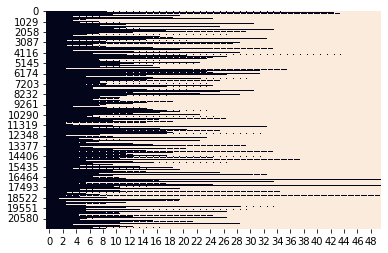

In [68]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [69]:
X_train.shape

(21601, 50)

In [70]:
corpus = X_test

## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=MAX_COLUMN_LENGTH,
             padding="post", truncating="post")

In [71]:
X_test.shape

(2800, 50)

In [72]:
embeddings = np.zeros((len(dic_vocabulary)+1, VECTOR_SIZE))

for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Deep Learning

Arsitektur jaringan Deep Learning yang digunakan adalah sebagai berikut:
- 1 Input Layer
- 1 Embedding Layer
- 2 Layer Biderictional LSTM
- 2 Dense Layer

Eksperimen tuning parameter akan dilakukan terhadap 2 paramater, yaitu batch_size dan epochs. Eksperimen tuning dilakukan dengan asumsi tidak ada ketergantungan antar-parameter.

In [73]:
## Input Layer
x_in = layers.Input(shape=(MAX_COLUMN_LENGTH,))

## Embedding Layer
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)

## 2 Layers of Bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

## Final Dense Layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)

## Compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'], run_eagerly=True)

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 300)           13387500  
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 30)           37920     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                1984      
                                                                 
 dense_3 (Dense)             (None, 2)                 130

In [74]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}

inverse_dic = {v:k for k,v in dic_y_mapping.items()}

y_train = np.array([inverse_dic[y] for y in y_train])


In [75]:
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

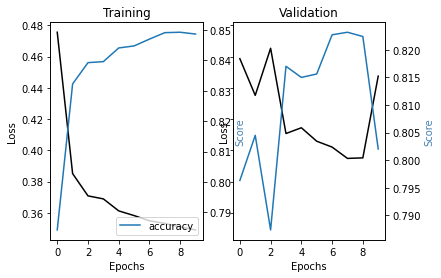

In [76]:
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [77]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

ACCURACY:  0.8307142857142857
PRECISION:  0.8436578171091446
RECALL:  0.4045261669024045
F1:  0.5468451242829827

CONFUSION MATRIX:


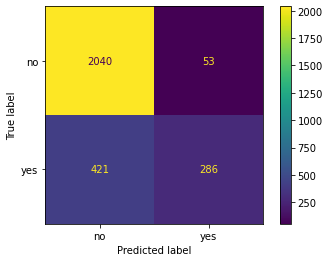

In [78]:
print("ACCURACY: ", accuracy_score(y_test, predicted))
print("PRECISION: ", precision_score(y_test, predicted, pos_label="yes"))
print("RECALL: ", recall_score(y_test, predicted, pos_label="yes"))
print("F1: ", f1_score(y_test, predicted, pos_label="yes"))
print()
print("CONFUSION MATRIX:")

cm = confusion_matrix(y_test, predicted, labels=["no","yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no","yes"])
disp.plot()
plt.show()

### Batch Size

In [79]:
batch_size_128 = models.Model(x_in, y_out)
batch_size_128.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'], run_eagerly=True)
history_batch_size_128 = model.fit(x=X_train, y=y_train, batch_size=128, 
                     shuffle=True,
                     validation_split=0.3)


119/119 [==============================] - 9s 73ms/step - loss: 0.3509 - accuracy: 0.8478 - val_loss: 0.3859 - val_accuracy: 0.8222


In [80]:
batch_size_256 = models.Model(x_in, y_out)
batch_size_256.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'], run_eagerly=True)
history_batch_size_256 = model.fit(x=X_train, y=y_train, batch_size=256, 
                     shuffle=True,
                     validation_split=0.3)


60/60 [==============================] - 5s 76ms/step - loss: 0.3430 - accuracy: 0.8510 - val_loss: 0.3843 - val_accuracy: 0.8298


In [81]:
batch_size_512 = models.Model(x_in, y_out)
batch_size_512.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'], run_eagerly=True)
history_batch_size_512 = model.fit(x=X_train, y=y_train, batch_size=512, 
                     shuffle=True,
                     validation_split=0.3)


30/30 [==============================] - 2s 78ms/step - loss: 0.3398 - accuracy: 0.8538 - val_loss: 0.3828 - val_accuracy: 0.8286


### Epochs

In [82]:
epoch_2 = models.Model(x_in, y_out)
epoch_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'], run_eagerly=True)
history_epoch_2 = model.fit(x=X_train, y=y_train, 
                            epochs=2,
                            batch_size=512, 
                            shuffle=True,
                            validation_split=0.3)

Epoch 1/2
30/30 [==============================] - 3s 87ms/step - loss: 0.3344 - accuracy: 0.8554 - val_loss: 0.3861 - val_accuracy: 0.8261
Epoch 2/2
30/30 [==============================] - 3s 85ms/step - loss: 0.3353 - accuracy: 0.8552 - val_loss: 0.3796 - val_accuracy: 0.8306


In [83]:
epoch_4 = models.Model(x_in, y_out)
epoch_4.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'], run_eagerly=True)
history_epoch_4 = model.fit(x=X_train, y=y_train, 
                            epochs=4,
                            batch_size=512, 
                            shuffle=True,
                            validation_split=0.3)

Epoch 1/4
30/30 [==============================] - 3s 85ms/step - loss: 0.3345 - accuracy: 0.8563 - val_loss: 0.3955 - val_accuracy: 0.8216
Epoch 2/4
30/30 [==============================] - 2s 83ms/step - loss: 0.3328 - accuracy: 0.8550 - val_loss: 0.3760 - val_accuracy: 0.8300
Epoch 3/4
30/30 [==============================] - 2s 74ms/step - loss: 0.3301 - accuracy: 0.8572 - val_loss: 0.3731 - val_accuracy: 0.8318
Epoch 4/4
30/30 [==============================] - 2s 74ms/step - loss: 0.3292 - accuracy: 0.8589 - val_loss: 0.3831 - val_accuracy: 0.8280


In [84]:
epoch_8 = models.Model(x_in, y_out)
epoch_8.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'], run_eagerly=True)
history_epoch_8 = model.fit(x=X_train, y=y_train, 
                            epochs=8,
                            batch_size=512, 
                            shuffle=True,
                            validation_split=0.3)

Epoch 1/8
30/30 [==============================] - 3s 84ms/step - loss: 0.3281 - accuracy: 0.8585 - val_loss: 0.3791 - val_accuracy: 0.8306
Epoch 2/8
30/30 [==============================] - 2s 75ms/step - loss: 0.3287 - accuracy: 0.8579 - val_loss: 0.3679 - val_accuracy: 0.8317
Epoch 3/8
30/30 [==============================] - 2s 75ms/step - loss: 0.3250 - accuracy: 0.8608 - val_loss: 0.3743 - val_accuracy: 0.8338
Epoch 4/8
30/30 [==============================] - 2s 83ms/step - loss: 0.3252 - accuracy: 0.8599 - val_loss: 0.4008 - val_accuracy: 0.8263
Epoch 5/8
30/30 [==============================] - 3s 87ms/step - loss: 0.3262 - accuracy: 0.8586 - val_loss: 0.3684 - val_accuracy: 0.8331
Epoch 6/8
30/30 [==============================] - 3s 84ms/step - loss: 0.3244 - accuracy: 0.8570 - val_loss: 0.3699 - val_accuracy: 0.8343
Epoch 7/8
30/30 [==============================] - 2s 75ms/step - loss: 0.3225 - accuracy: 0.8612 - val_loss: 0.3716 - val_accuracy: 0.8338
Epoch 8/8
30/30 [===